In [1]:
#Create a neural network graph and setup training steps for 
# a neural network to use and learn from the MNIST dataset.

# Import modules necessary for MNIST Experiment
import tensorflow as tf

#Import example
from tensorflow.examples.tutorials.mnist import input_data
#Setup data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
import tensorflow as tf
import numpy as np

tf.reset_default_graph()

#Define model

# Create the model
x = tf.placeholder(tf.float32, [None, 784]) #Input values (N images by 784 pixels per image)
W = tf.Variable(tf.zeros([784, 10]))        #Weight values for input (784 pixels by 10 possible digits)
b = tf.Variable(tf.zeros([10]))             #Bias values for each digit
y = tf.nn.softmax(tf.matmul(x, W) + b)      #Output vector, Softmax(Wx + b)

# Define loss placeholder
y_ = tf.placeholder(tf.float32, [None, 10]) #How far is result from actual

# Create cross_entropy function based on loss and actual
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

# Instruct TensorFlow to attempt to minimize the cross_entropy using the Gradient Descent 
# Optimizer with a learning value of 0.5
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

# Initialize and save variables
init = tf.global_variables_initializer()

#add operations to save and restore all the variables
saver = tf.train.Saver([W,b])

#Start new Session
sess = tf.Session()

## Values used to collect data
#Number of steps to run
num_steps = 500
#Number of samples for data collection
n_samples = 500
#Number of steps between sample collection
sample_gap = 50

#Save step numbers of each data point
points = num_steps // sample_gap + 1
step_nums = np.zeros(shape=(points))

#Save accuracy at all points
guess_accuracy = np.zeros(shape=(num_steps + 1))

#Define a way to save parameters for graph
graphs = np.zeros(shape=(points, n_samples, 2))
solutions = np.zeros(shape=(points, n_samples))
#Define a way to save weight images
weight_images = np.zeros(shape=(points, 10, 28, 28))
#Define batch size
batch_size = 100

#Initialize variables
sess.run(init)

In [4]:
#Create a neural network and save values for display

# importing the required packages
import numpy as np
from sklearn import manifold

#Ignore divide by zero errors, only rare and on first frame
np.seterr(divide='ignore', invalid='ignore')

#Setup function for computing t-SNE for graphs
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
    
# Define way to check session and run the function with test data
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))    #Define function to calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))  #Define function to display result

# Run training steps Num Steps times
for n in range(num_steps):
    #Get a batch of 100 images
    #Batch_x are the input images as a flattened 784 pixel vector
    #Batch_y is a vector of what number the image represents
    batch_x, batch_y = mnist.train.next_batch(batch_size)
    
    #Evaluate current accuracy
    guess_accuracy[n] = sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
    
    #Run the session with the given data (Do one training step)
    sess.run(train_step, feed_dict={x: batch_x, y_: batch_y})
    
    #Log data every gap number of steps
    #Ignore index 0 as all values are set to zero and this can lead to errors
    #Add data point for last frame also
    if n // sample_gap < num_steps // sample_gap and \
            n % sample_gap == 0 or n == num_steps - 1:
        
        print("Calculating visual representation, step", n)
        #Load n samples from the training dataset
        #Batch_x are the input images as a flattened 784 pixel vector
        #Batch_y is a vector of what number the image represents
        batch_x, batch_y = mnist.train.next_batch(n_samples)
        X = sess.run(y, feed_dict={x:batch_x})
        
        index = n // sample_gap
        #If last frame, rig indices so it is put in last spot
        if (n == num_steps - 1):
            index = step_nums.shape[0] - 1
        
        # (This is slow but precomputed) Computing t-SNE projection
        tsne_vector = tsne.fit_transform(X)
        graphs[index] = tsne_vector;
        
        #Save the solution to this batch
        solutions[index] = np.array([np.argmax(group) for group in batch_y])
                         
        #Save weight images to display later
        weight_images[index] = np.array([np.reshape(sess.run(W)[np.arange(0,784), n], (-756,28)) for n in range(10)])
        
        #Save step number
        step_nums[index] = int(n + 1)
    
#Evaluate current accuracy
guess_accuracy[num_steps] = sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels})

Calculating visual representation, step 0
Calculating visual representation, step 50
Calculating visual representation, step 100
Calculating visual representation, step 150
Calculating visual representation, step 200
Calculating visual representation, step 250
Calculating visual representation, step 300
Calculating visual representation, step 350
Calculating visual representation, step 400
Calculating visual representation, step 450
Calculating visual representation, step 499


In [6]:
#Evaluate the model

# Define way to check session and run the function with test data
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))    #Define function to calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))  #Define function to display result
a = sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
print("Accuray of prediction is " + 
      str(int(10000 * a) /100) + "%");

Accuray of prediction is 91.62%


In [5]:
# Save the neural network and data out to the disk

import os
import numpy as np

path = os.getcwd()

#Ensure that there is a directory to save the neural network in
if not os.path.isdir(os.path.join(path,"simpleNN")):
    os.makedirs(os.path.join(path,"simpleNN"))
save_path = saver.save(sess, os.path.join(path,"simpleNN","mnistNN.ckpt"))
#Log saving the file
print("Neural network saved to '%s'" % save_path)

#Ensure that there is a directory to save the data in
if not os.path.isdir(os.path.join(path,"NNData")):
    os.makedirs(os.path.join(path,"NNData"))
#Setup data and filenames to save
info = [graphs, solutions, weight_images, step_nums]
names = ["graphs.npy", "solutions.npy", "weight_images.npy", "step_nums.npy"]

#Iterate and save each piece of data
for index in range(len(info)):
    save_path = os.path.join(path,"NNData",names[index])
    np.save(save_path, info[index])
    print("Saved out data to '%s'" % save_path)

Neural network saved to 'C:\Users\mals7h\Documents\TFDemo\simpleNN\mnistNN.ckpt'
Saved out data to 'C:\Users\mals7h\Documents\TFDemo\NNData\graphs.npy'
Saved out data to 'C:\Users\mals7h\Documents\TFDemo\NNData\solutions.npy'
Saved out data to 'C:\Users\mals7h\Documents\TFDemo\NNData\weight_images.npy'
Saved out data to 'C:\Users\mals7h\Documents\TFDemo\NNData\step_nums.npy'


In [36]:
# Load data from disk to neural network and plotting information

import os

path = os.getcwd()

#Initialize variables
sess.run(init)

#Restore the neural network (if it exists)
save_path = os.path.join(path,"simpleNN", "mnistNN.ckpt.meta")
if os.path.isfile(save_path):
    # Restore neural network instead of loading values
    saver.restore(sess, os.path.join(path,"simpleNN", "mnistNN.ckpt"))
    print("Neural network loaded from file '%s'" % save_path)
    
save_path = os.path.join(path, "NNData", "graphs.npy")
if os.path.isfile(save_path):
    graphs = np.load(save_path)
    print("Graph data loaded from file '%s'" % save_path)

save_path = os.path.join(path, "NNData", "solutions.npy")
if os.path.isfile(save_path):
    solutions = np.load(save_path)
    print("Solution data loaded from file '%s'" % save_path)

save_path = os.path.join(path, "NNData", "weight_images.npy")
if os.path.isfile(save_path):
    weight_images = np.load(save_path)
    print("Weight image data loaded from file '%s'" % save_path)

save_path = os.path.join(path, "NNData", "step_nums.npy")
if os.path.isfile(save_path):
    step_nums = np.load(save_path)
    print("Step Number data loaded from file '%s'" % save_path)


INFO:tensorflow:Restoring parameters from C:\Users\mals7h\Documents\TFDemo\simpleNN\mnistNN.ckpt
Neural network loaded from file 'C:\Users\mals7h\Documents\TFDemo\simpleNN\mnistNN.ckpt.meta'
Graph data loaded from file 'C:\Users\mals7h\Documents\TFDemo\NNData\graphs.npy'
Solution data loaded from file 'C:\Users\mals7h\Documents\TFDemo\NNData\solutions.npy'
Weight image data loaded from file 'C:\Users\mals7h\Documents\TFDemo\NNData\weight_images.npy'
Step Number data loaded from file 'C:\Users\mals7h\Documents\TFDemo\NNData\step_nums.npy'


<IPython.core.display.Javascript object>


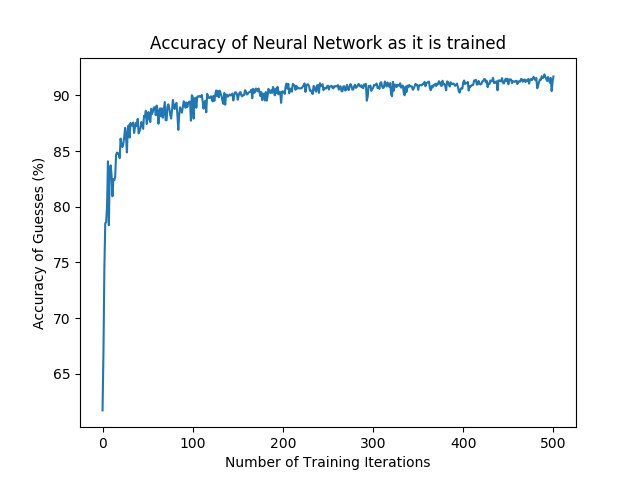

In [80]:
# Plot the accuracy over time

import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(guess_accuracy * 100)
ax.set_xlabel('Number of Training Iterations')
ax.set_ylabel('Accuracy of Guesses (%)')
ax.set_title('Accuracy of Neural Network as it is trained')
plt.show()

<IPython.core.display.Javascript object>


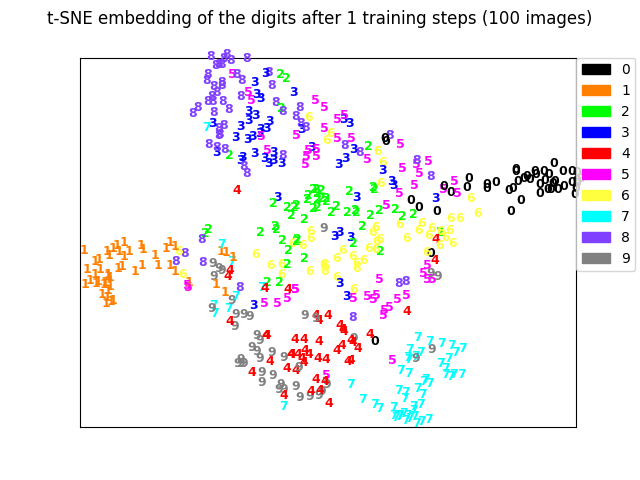

In [96]:
# Take the precomputed information and make an interactive graph to showcase the neural network

#Import required libraies
from ipywidgets import interact
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Define colors for plotting numbers
colors = [(0,0,0,1),        #Black for zero
            (1, .5,0, 1),   #Orange for one
            (0, 1, 0, 1),   #Green for two
            (0, 0, 1, 1),   #Blue for three
            (1, 0, 0, 1),   #Red for four
            (1, 0, 1, 1),   #Magenta for five
            (1, 1, .25, 1), #Yellow for six
            (0, 1, 1, 1),   #Teal for seven
            (.5, .25, 1, 1),#Purple for eight
            (.5, .5, .5, 1)#Grey for nine
         ]

%matplotlib notebook

graph_fig = plt.figure()

def update(time_index = 0):
    frame = step_nums[time_index]
    
    #Update t-SNE Graph
    plt.figure(graph_fig.number)
    
    title="t-SNE embedding of the digits"
    #Save the vectors for this plot
    X = graphs[time_index]
    
    #Clear canvas
    graph_fig.clf()
    
    #Calculate min and max of graphs
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    #Normalize values based on input
    X = (X - x_min) / (x_max - x_min)     
    ax = plt.subplot(111)
    for i in range(n_samples):
        num = int(solutions[time_index][i])
        plt.text(X[i, 0], X[i, 1], str(num),
                 color=colors[num],
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([]), plt.yticks([])
    plt.suptitle(title + " after " + str(int(frame)) + " training steps (" + \
        str(int(frame * batch_size)) + " images)")
        
    patches = [mpatches.Patch(color=colors[i], label=str(i)) for i in range(10)]
    plt.legend(handles=patches,bbox_to_anchor=(1.001, 1), loc=2, borderaxespad=0.)
    plt.show()
    
interact(update, time_index = (0, len(graphs) - 1));

<IPython.core.display.Javascript object>


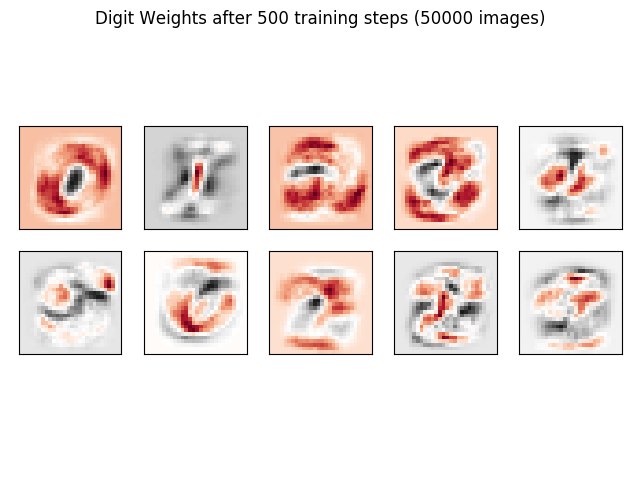

In [97]:
from matplotlib import cm
from matplotlib import pyplot

%matplotlib notebook

dig_fig = plt.figure()

def update(time_index = 0):
    frame = step_nums[time_index]
    images = weight_images[time_index]

    for i in range(10):
        plt.subplot(2, 5, i + 1)
        pyplot.imshow(-images[i], interpolation='nearest', cmap=cm.RdGy)
        plt.xticks([]), plt.yticks([])
    
    plt.suptitle("Digit Weights after " + str(int(frame)) + " training steps (" + 
                  str(int(frame * batch_size)) + " images)")
    
    plt.tight_layout()
    pyplot.show()

interact(update, time_index = (0, len(graphs) - 1));

In [3]:
sess.run(W[:,1])

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0